In [1]:
import os
import shutil
import random
from torchvision import datasets, models
from torchvision.transforms import v2 as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import models
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score


print(torch.__version__)
print(torchvision.__version__)

2.5.0
0.20.0


### Загрузим данные и раскидаем все по train, val, test

In [2]:
raw_dataset = './raw_data'
splitted_dataset = './splitted_data'

In [3]:
if not os.path.exists(splitted_dataset):
    os.mkdir(splitted_dataset)

In [4]:
train_dir = os.path.join(splitted_dataset, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)

In [5]:
val_dir = os.path.join(splitted_dataset, 'val')
if not os.path.exists(val_dir):
    os.mkdir(val_dir)

In [6]:
test_dir = os.path.join(splitted_dataset, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

In [7]:
#classes = ['glioma', 'healthy', 'meningioma', 'pituitary']
classes = [d for d in os.listdir(raw_dataset) if os.path.isdir(os.path.join(raw_dataset, d))]
print(classes)

['pituitary', 'healthy', 'glioma', 'meningioma']


In [8]:
#make folders for each class inside each bucket (train val test)
for cls in classes:
    train_full = os.path.join(train_dir, cls)
    if not os.path.exists(train_full):
        os.mkdir(train_full)

    val_full = os.path.join(val_dir, cls)
    if not os.path.exists(val_full):
        os.mkdir(val_full)
    
    test_full = os.path.join(test_dir, cls)
    if not os.path.exists(test_full):
        os.mkdir(test_full)

In [9]:
# разделим наши файлы по train test val
for cls in classes:
    cls_dir = os.path.join(raw_dataset, cls)
    files = [f for f in os.listdir(cls_dir) if os.path.isfile(os.path.join(cls_dir, f))]

    #проверим не пустая ли папка
    if len(files) == 0:
        print(f'В папке {os.path(cls_dir)} нет файлов')
        continue
    
    random.seed(42)
    random.shuffle(files)
    # определяем сколько файлов по трейн валу и тесту будем кидать в процентах
    train_split = int(0.7 * len(files))
    val_split = int(0.2 * len(files))
    test_split = int(0.1 * len(files))

    train_files = files[:train_split]
    val_files = files[train_split:train_split + val_split]
    test_files = files[train_split + val_split:]

    print(f'Class {cls}')
    print(f'Total files: {len(files)}')
    print(f'Train_split: {len(train_files)}')
    print(f'Validation_split: {len(val_files)}')
    print(f'Test_split: {len(test_files)}')

    #теперь скопируем файлы из оригинальной папки в эту сложную систему папок, накатаем функцию
    def copy_files(file_list, src_dir, dst_dir):
        for file in file_list:
            src = os.path.join(src_dir, file)
            dst = os.path.join(dst_dir, cls, file)
            shutil.copyfile(src, dst)
    
    copy_files(train_files, cls_dir, train_dir)
    copy_files(val_files, cls_dir, val_dir)
    copy_files(test_files, cls_dir, test_dir)
    
    print("Разделение данных завершено")


Class pituitary
Total files: 1757
Train_split: 1229
Validation_split: 351
Test_split: 177
Разделение данных завершено
Class healthy
Total files: 2000
Train_split: 1400
Validation_split: 400
Test_split: 200
Разделение данных завершено
Class glioma
Total files: 1621
Train_split: 1134
Validation_split: 324
Test_split: 163
Разделение данных завершено
Class meningioma
Total files: 1645
Train_split: 1151
Validation_split: 329
Test_split: 165
Разделение данных завершено


### Определим свойства трансформера этих данных 

In [10]:
train_transforms = transforms.Compose([
    transforms.Resize(size =(224, 224)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomRotation(degrees = 10),
    transforms.ToImage(),
    transforms.ToDtype(dtype = torch.float32, scale = True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [11]:
val_transforms = transforms.Compose([
    transforms.Resize(size =(224, 224)),
    transforms.ToImage(),
    transforms.ToDtype(dtype = torch.float32, scale = True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [12]:
test_transforms = transforms.Compose([
    transforms.Resize(size =(224, 224)),
    transforms.ToImage(),
    transforms.ToDtype(dtype = torch.float32, scale = True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Apply Transformations


In [13]:
train_dataset = datasets.ImageFolder(root = train_dir, transform = train_transforms)
val_dataset = datasets.ImageFolder(root = val_dir, transform = val_transforms)
test_dataset = datasets.ImageFolder(root = test_dir, transform = test_transforms)

In [14]:
# Проверка классов
print("Классы:", train_dataset.classes)

Классы: ['glioma', 'healthy', 'meningioma', 'pituitary']


# Создадим даталоадеры что бы иметь удобную настройку batch size, многопоточность при загрузке

In [15]:
batch_size = 64
num_workers = 8

In [16]:
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers)
val_loader = DataLoader(dataset = val_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers)


In [17]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Device used: {device}')

Device used: mps


In [18]:
model = models.resnet18(weights = torchvision.models.ResNet18_Weights.DEFAULT)

In [19]:
num_classes = len(train_dataset.classes)
num_ftrs = model.fc.in_features
print(f'Model specs:\n============\nNum classes: {num_classes}\nNum Features: {num_ftrs}')

Model specs:
Num classes: 4
Num Features: 512


In [20]:
model.fc = torch.nn.Linear(num_ftrs, num_classes)

In [21]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Модель только со всеми замороженными параметрами кроме параметров FC

In [22]:
for parameter in model.parameters():
    parameter.requires_grad = False
for parameter in model.fc.parameters():
    parameter.requires_grad = True

In [23]:
model = model.to(device)

In [24]:
optimizer = torch.optim.SGD(model.fc.parameters(), lr = 0.001, momentum = 0.9)


##### Loss Function

In [25]:
criterion = torch.nn.CrossEntropyLoss()

##### Функция обучения


In [26]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []  # Список для хранения предсказанных классов
    all_labels = []  # Список для хранения истинных меток

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs= model(inputs) ### прямой проход
        loss = criterion(outputs, labels) ### рассчет функции потерь
        loss.backward() ### обратный проход
        optimizer.step() ### обновление параметров

        running_loss += loss.item() * inputs.size(0) # возвращает первую ось тензора где сожержится размер батча, например тензор изначально как
                                                    # (64, 3, 224, 224) и возьмется соответсвенно 64
        _, preds= torch.max(outputs, 1) # возвращает 2 объекта - первый реальный probability максимальный из всех классов, второй индекс класса (или просто класс)
        correct += (preds == labels).sum().item() # предсказания равны лейблам, сумма, превратить в число из тензора
        total += labels.size(0) # количество лейблов по сути, а именно 


    epoch_loss = running_loss/total # средняя потеря за эпоху в виде накопишвегося лосс поделить на общее количество примеров
    epoch_acc = correct/total # точность

    return epoch_loss, epoch_acc # Возвращаем метрики



In [27]:
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval() #переводим модель в режим оценки
    running_loss = 0.0
    correct = 0 
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            # Вычисление точности
            _, preds = torch.max(outputs, 1)  # Получаем предсказанные классы
            correct += (preds == labels).sum().item()  # Считаем правильные предсказания
            total += labels.size(0)  # Общее количество образцов

    epoch_loss = running_loss / total  # Средняя потеря за эпоху
    epoch_acc = correct / total        # Точность за эпоху

    return epoch_loss, epoch_acc  # Возвращаем потери и точность

In [32]:
# Тестирование модели на тестовом наборе данных
test_loss, test_acc = validate_one_epoch(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')

Test Loss: 0.2704 Acc: 0.9092


In [28]:
num_epochs = 20
history = {
    'train_loss':[],
    'train_acc':[],
    'val_loss':[],
    'val_acc':[]
}
best_val_acc = 0.0

In [29]:
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    # Обучение одной эпохи
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')

    # Валидация на одной эпохе
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = model.state_dict()


Epoch 1/20
----------
Train Loss: 0.9251 Acc: 0.6445
Validation Loss: 0.6065 Acc: 0.8127
Epoch 2/20
----------
Train Loss: 0.5402 Acc: 0.8242
Validation Loss: 0.4922 Acc: 0.8412
Epoch 3/20
----------
Train Loss: 0.4692 Acc: 0.8394
Validation Loss: 0.4353 Acc: 0.8511
Epoch 4/20
----------
Train Loss: 0.4394 Acc: 0.8484
Validation Loss: 0.4124 Acc: 0.8583
Epoch 5/20
----------
Train Loss: 0.4124 Acc: 0.8539
Validation Loss: 0.3925 Acc: 0.8697
Epoch 6/20
----------
Train Loss: 0.3990 Acc: 0.8592
Validation Loss: 0.3947 Acc: 0.8611
Epoch 7/20
----------
Train Loss: 0.3865 Acc: 0.8632
Validation Loss: 0.3732 Acc: 0.8647
Epoch 8/20
----------
Train Loss: 0.3786 Acc: 0.8655
Validation Loss: 0.3643 Acc: 0.8697
Epoch 9/20
----------
Train Loss: 0.3600 Acc: 0.8689
Validation Loss: 0.3500 Acc: 0.8746
Epoch 10/20
----------
Train Loss: 0.3540 Acc: 0.8708
Validation Loss: 0.3474 Acc: 0.8725
Epoch 11/20
----------
Train Loss: 0.3515 Acc: 0.8763
Validation Loss: 0.3363 Acc: 0.8754
Epoch 12/20
-------

In [30]:
# Загрузим лучшие полученные параметры модели
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)
    print(f'Best accuracy on validation {best_val_acc:.4f}')

Best accuracy on validation 0.8868


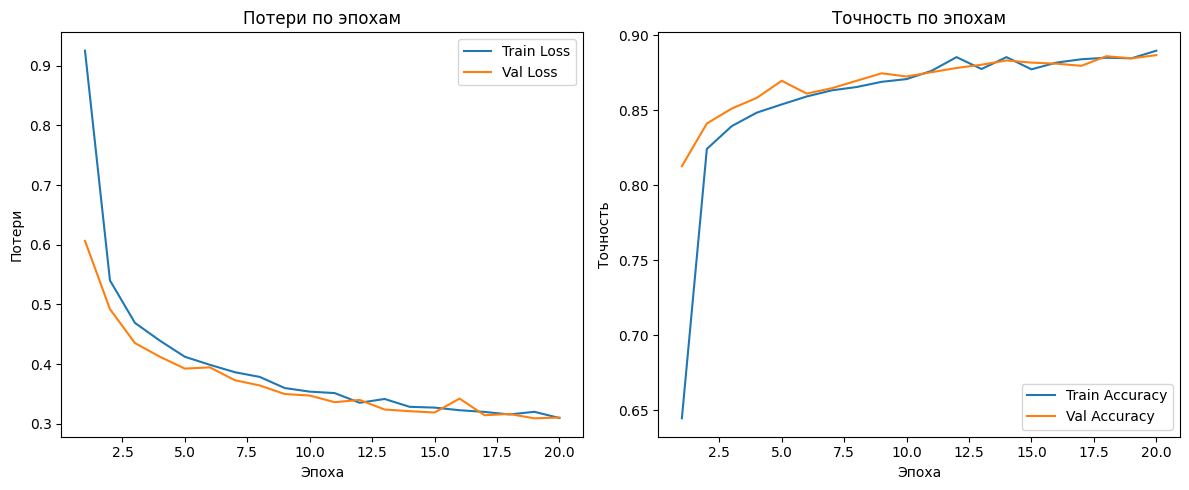

In [31]:
# Визуализация
plt.figure(figsize = (12,5))

# Потери Loss
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs + 1), history['train_loss'], label = 'Train Loss')
plt.plot(range(1, num_epochs + 1), history['val_loss'], label= 'Val Loss')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Потери по эпохам')
plt.legend()

# Accuracy Точность
plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), history['train_acc'], label='Train Accuracy')
plt.plot(range(1, num_epochs+1), history['val_acc'], label='Val Accuracy')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.title('Точность по эпохам')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# сохраним нашу модель
torch.save(model.state_dict(), 'best_model.pth')
print('Модель сохранена как best_model.pth')